# Milestone 4 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Kela Roberts<br>

## Deliverables

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc.
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc.
- Discussion of the results, how much improvement you gained with fine tuning, etc.
- Discussion of at least one additional exploratory idea you pursued

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import random
from PIL import Image
from PIL import ImageEnhance
import PIL.ImageOps
from six.moves import cPickle as pickle
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Conv3D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3

from keras import backend as K
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np
from time import time, sleep

Using TensorFlow backend.


## Overview

In this milestone, we will use movie posters extracted from TMDb to develop deep learning networks for the task of multi-label movie genre prediction. We will train one small convolutional neural network (CNN) from scratch using Keras with TensorFlow backend, as well as fine-tune another existing pre-trained network, and compare their results. To speed up computation, the models were run on the "p2.xlarge" GPU compute instances on Amazon Web Services (AWS)'s Elastic Compute Cloud (EC2).

---

## Data Preparation

Previously, we have downloaded posters for about 69,000 movies from TMDb in w154 resolution (154x231 pixels) and `.jpg` format. Here, we use the Python Imaging Library (PIL) to pre-process these `.jpg` images into matrices of pixel values. All posters are resized to 154x154 pixels and then their RGB channel values are extracted into matrices of dimensions 154x154x3.

We also stored the corresponding genre labels (there are a total of 19 different genres) in a separate pickle file. To limit output file sizes, we processed the posters in batches of 1000 posters (total 69 batches).

In [5]:
genres = pd.read_csv('../data/clean_data/genres_70k_new.txt')
genres = genres.drop('TVMovie', 1)

In [6]:
tmdb_index_dict={}
for i in range(genres.shape[0]):
    tmdb_index_dict[genres.iloc[i,0]]=i

In [7]:
DATA_PATH = "/home/ubuntu/new_data/data/poster_154/"
SAVE_PATH="/home/ubuntu/new_data/data/poster_154_resize/"
VALIDATION_PERCENT = .2
TEST_PERCENT = .2
IMAGE_WIDTH = 154
IMAGE_HEIGHT=154
IMAGE_SIZE=154
NUM_CHANNELS = 3 #RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
PARTITION_TEST = False

In [8]:
def to_rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, :] = im[:, :, np.newaxis]
    return ret
def read_image_from_file(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT), Image.ANTIALIAS) #downsample image
    pixel_values = np.array(img.getdata())
    return np.reshape(pixel_values, [IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS])
def make_dataset_arrays(num_rows=NUM_ROWS):
    data = np.ndarray((num_rows, IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS), dtype=np.float32)
    labels = np.ndarray((num_rows, NUM_GENRES), dtype=np.int32)
    return data, labels
def scale_pixel_values(dataset):
    return (dataset - PIXEL_DEPTH / 2.0) / PIXEL_DEPTH


In [9]:
train_data, train_labels = make_dataset_arrays()
num_train = 0
num_group=0
startTime = time()
for filename in os.listdir(DATA_PATH):
    if filename.endswith(".jpg"): 
        
        if num_train<NUM_ROWS:
            image=read_image_from_file(DATA_PATH+filename)
            tmdb_id=int(filename.split(".")[0])
            index=tmdb_index_dict[tmdb_id]
            labels=genres.iloc[index,1:]
            train_data[num_train]=image
            train_labels[num_train]=labels
            num_train+=1
        else:
            pickle_file = SAVE_PATH+str(num_group)+'_data.pickle'
            save = {
                'train_data': train_data,
                'train_labels': train_labels,
            }
            pickle.dump(save,open(pickle_file, 'wb'))
            train_data = scale_pixel_values(train_data)
            train_data, train_labels = make_dataset_arrays()
            num_train = 0
            num_group+=1
            endTime = time()-startTime
            startTime = time()
            print(num_group,endTime)
    else:
        continue


1 23.07148838043213
2 23.129584550857544
3 23.35673761367798
4 23.262993574142456
5 23.149495124816895
6 23.00201940536499
7 22.927311897277832
8 22.939159154891968
9 23.064728498458862
10 22.971879959106445
11 23.085129499435425
12 24.443018674850464
13 24.3766028881073
14 24.22775650024414
15 24.348602533340454
16 24.058658599853516
17 24.22340726852417
18 24.41267442703247
19 24.15579056739807
20 24.253930807113647
21 25.006831407546997
22 24.567741632461548
23 24.416815280914307
24 24.119917392730713
25 24.19269037246704
26 24.41075086593628
27 24.368112564086914
28 24.50965452194214
29 25.553877592086792
30 24.256695985794067
31 24.258487701416016
32 24.21980881690979
33 24.34823703765869
34 24.676378965377808
35 24.258639335632324
36 24.213446617126465
37 23.88783574104309
38 24.61973214149475
39 25.433425426483154
40 25.156229496002197
41 24.31625986099243
42 24.32528328895569
43 25.392767429351807
44 24.759549140930176
45 24.387789726257324
46 24.285592794418335
47 24.701051712

---

## Training a Network from Scratch

In view of computation time and to focus on the correctness of our code (for now), we only used 10,000 posters (10 batches) for training and 5,000 posters (5 batches) for testing, even though we had data for 69,000 posters (69 batches). As the posters were grouped into batches in no particular pattern, this represents a random sampling. We intend to increase the number of training and testing samples for our final project milestone, and perhaps cherry pick posters (see discussion below).

### Network Architecture & Parameter Settings

The architecure of our CNN is as follows:
- [154x154x3] INPUT: 154x154 RGB image
- [150x150x32] CONV1: 32 5x5 filters at stride 1, pad 0
- [148x148x32] CONV2: 32 3x3 filters at stride 1, pad 0
- [74x74x32] MAXPOOL1: 2x2 filters at stride 2
- [72x72x32] CONV3: 32 3x3 filters at stride 1, pad 0
- [70x70x32] CONV4: 32 3x3 filters at stride 1, pad 0
- [35x35x32] MAXPOOL2: 2x2 filters at stride 2
- FC1: 64 neurons
- FC2: 19 neurons (output classes)

Other design choices made are as follows:
- Activation function: Rectified linear unit (ReLU) for hidden layers, sigmoid for output layer
- Optimization method: Adam
- Loss function: Binary cross-entropy
- Dropout: 0.25 on hidden layer, 0.5 on fully-connected layer
- Regularization: None (for now, KIV to add L2)
- Weight initialization: Glorot uniform
- Data pre-processing: Centering and normalization
- Data augmentation: Re-scaling, rotation, width shift, height shift, horizontal flip

The main parameters of our network are as follows:
- Learning rate: 0.1, reduced by factor of 0.2 when validation loss plateaus for 1 epoch, until minimum of 0.001
- Batch size: 500
- Number of epochs: 20 (fixed for now, KIV to add early stopping when validation loss plateaus for X number of epochs)

In [21]:
DATA_PATH = "/home/ubuntu/new_data/data/poster_154/"
SAVE_PATH="/home/ubuntu/new_data/data/poster_154_resize/"
VALIDATION_PERCENT = .2
TEST_PERCENT = .2
IMAGE_WIDTH = 154
IMAGE_HEIGHT=154
IMAGE_SIZE=154
NUM_CHANNELS = 3 #RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
input_shape = ( IMAGE_WIDTH,IMAGE_HEIGHT, 3)
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 500
# this is fixed, we have 10 digits in our data set
num_classes = NUM_GENRES
# number of iterations over the complete training data
epochs = 20
##sample batch
num_batch=15

In [22]:
input_shape = ( IMAGE_WIDTH,IMAGE_HEIGHT, 3)
#sample_index=random.sample(range(69), num_batch)
sample_index=np.arange(25)
train_index=sample_index[:10]
test_index=sample_index[10:]
num_test=len(test_index)*NUM_ROWS
num_train=len(train_index)*NUM_ROWS
train_X=np.zeros((num_train,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
train_Y=np.zeros((num_train,NUM_GENRES))
test_X=np.zeros((num_test,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
test_Y=np.zeros((num_test,NUM_GENRES))

In [ ]:
for i in range(len(train_index)):
    file_name=str(train_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        train_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [13]:
for i in range(len(test_index)):
    file_name=str(test_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        test_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        test_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [14]:
print(test_X.shape)

(15000, 154, 154, 3)


In [15]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [34]:
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_GENRES,activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 32)        0         
__________

In [41]:
adam=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.1, momentum=0.9)
#early_stopping = EarlyStopping(monitor='val_loss',patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=1, min_lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [42]:
history = model.fit_generator(datagen.flow(train_X, train_Y,batch_size=batch_size), 
                    steps_per_epoch=len(train_X) / batch_size,
                    epochs=epochs,
                    validation_data=datagen.flow(test_X, test_Y),
                    validation_steps=len(test_X) / batch_size,
                    callbacks=[reduce_lr])

Epoch 1/20
20/20 [==============================] - 54s - loss: 5.0437 - acc: 0.6840 - val_loss: 5.2339 - val_acc: 0.6720

### Network Performance

Our network achieved a test accuracy of 38%. We think its poor performance is due to insufficient optimization of our model architecture and settings, and we hope to improve on this with more time for parameter tuning.

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 25.4279073944
Test accuracy: 0.3774


Here, we visualize the accuracy over the training process. The accuracy appears to have plateaued after the 2nd epoch.

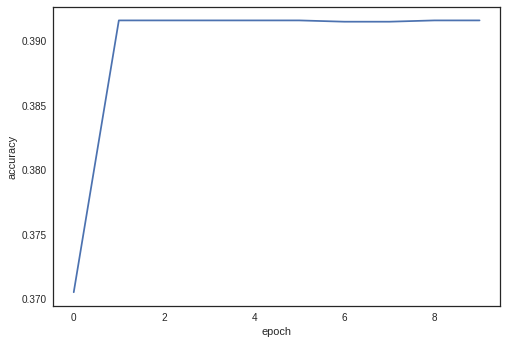

In [37]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [ ]:
sgd = SGD(lr=0.1, momentum=0.9)
#optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
history = model.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_X, test_Y))

### Features Learnt

Visualize filters

---

## Fine-tuning a Pre-trained Network

### Setup 
Note: Same as above, however, in order to pick up the file from here, the same settings are copied.

In [2]:
SAVE_PATH="/data/poster_154_resize/"
IMAGE_WIDTH = 154
IMAGE_HEIGHT=154
IMAGE_SIZE=154
NUM_CHANNELS = 3 #RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 500
# this is fixed, we have 10 digits in our data set
num_classes = NUM_GENRES
classes = NUM_GENRES
# number of iterations over the complete training data
epochs = 20
##sample batch
num_batch=15

In [24]:
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT, 3)
#sample_index=random.sample(range(69), num_batch)
sample_index=np.arange(40)
train_index=sample_index[:20]
test_index=sample_index[20:30]
val_index=sample_index[30:]
num_test=len(test_index)*NUM_ROWS
num_train=len(train_index)*NUM_ROWS
num_val=len(val_index)*NUM_ROWS
train_X=np.zeros((num_train,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
train_Y=np.zeros((num_train,NUM_GENRES))
test_X=np.zeros((num_test,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
test_Y=np.zeros((num_test,NUM_GENRES))
val_X=np.zeros((num_val,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
val_Y=np.zeros((num_val,NUM_GENRES))

In [28]:
# Training data
for i in range(len(train_index)):
    file_name=str(train_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        train_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [29]:
# Test data
for i in range(len(test_index)):
    file_name=str(test_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        test_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        test_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [30]:
# Validation data
for i in range(len(val_index)):
    file_name=str(val_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        val_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        val_Y[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']

In [31]:
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(20000, 154, 154, 3)
(10000, 154, 154, 3)
(10000, 154, 154, 3)


#### Parameters

In [32]:
final_activation_function = 'softmax'
input_activation_function = 'relu'
input_kernel_size = (5, 5)
input_shape = (154, 154, 3)
pool_size = (3, 3)
hidden_activation_function = 'relu'
hidden_kernel_size = (3, 3)
loss_method = 'binary_crossentropy'
optimizer = SGD(lr=0.1, momentum=0.9)
eval_metric = 'accuracy'

#### Load existing model

In [33]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [34]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer 
predictions = Dense(classes, activation=final_activation_function)(x)

In [35]:
# this is the model we will train
model_tune = Model(inputs=base_model.input, outputs=predictions)

#### Train the top layers
Step 1: train only the top layers (which were randomly initialized), i.e. freeze all convolutional InceptionV3 layers

In [36]:
for layer in model_tune.layers:
    layer.trainable = False

In [37]:
# compile the model (should be done *after* setting layers to non-trainable)
model_tune.compile(optimizer='rmsprop', loss='binary_crossentropy',  metrics=[eval_metric])

In [38]:
model_tune.layers

#### Training

Second: Train the model on the new data for a few epochs, then fine-tune the model

In [39]:
epochs = 10
tune_history = model_tune.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (test_X, test_Y))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 112s - loss: 0.3830 - acc: 0.8955 - val_loss: 0.4103 - val_acc: 0.8943

#### Scoring

In [40]:
# Evaluate the performance on the unused testing set.
score_tune = model_tune.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score_tune[0])
print('Test accuracy:', score_tune[1])

Test loss: 0.382483073807
Test accuracy: 0.895926178932


#### Visualization
The plot below shows the training process.

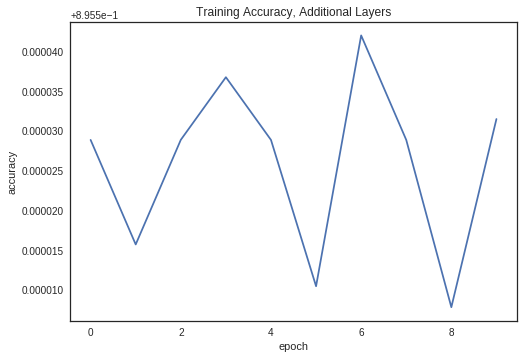

In [41]:
plt.plot(tune_history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training Accuracy, Additional Layers");

We now have a well trained top layers. This means, that we can start fine-tuning the convolutional layers from the inception V3 model. In order to do this the bottom N layers are frozen and we train the remaining top layers.

#### Print layer names and indices
First we visualize the layer names and indices (in order to see how many layers to freeze)

In [42]:
for i, layer in enumerate(model_tune.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [43]:
for layer in model_tune.layers[:172]:
   layer.trainable = False
for layer in model_tune.layers[172:]:
   layer.trainable = True

In order for the above adjustments to take effekt, the model has to be recombiled. We're also using SGD with a low learning rate.

In [44]:
model_tune.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy',  metrics=[eval_metric])

In [45]:
# Fine tune the new model, using the "fine" parameters of SGD previously defined.
epochs = 50
tune_history = model_tune.fit(train_X, train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (test_X, test_Y))

Train on 20000 samples, validate on 10000 samples
Epoch 1/50
20000/20000 [==============================] - 142s - loss: 0.3806 - acc: 0.8955 - val_loss: 0.3791 - val_acc: 0.8951

#### Scoring

In [46]:
# Evaluate the performance on the unused testing set.
score_tune = model_tune.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score_tune[0])
print('Test accuracy:', score_tune[1])

Test loss: 0.327134285688
Test accuracy: 0.895863021469


#### Visualization
The plot below shows the training process. As can be seen, the biggest gain is in the first epoch. From that we're seeing diminishing return.

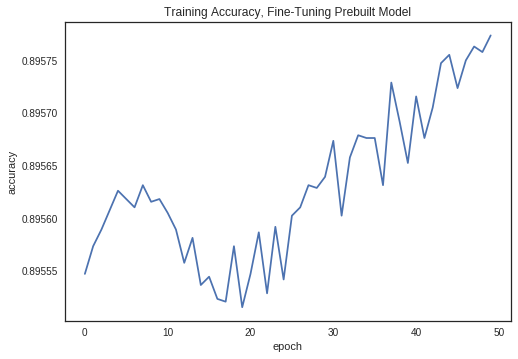

In [47]:
plt.plot(tune_history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training Accuracy, Fine-Tuning Prebuilt Model");

#### Look at the layers

---

## Discussion

Our networks had several weaknesses which we plan to address as follows:
- Further tuning of the network's architecture and parameters to improve performance, such as increasing the number of convolutional filters and number of neurons in the dense layer, decreasing the learning rate and batch size, etc.
- Increase the number of training and testing samples, and perhaps cherry pick posters we want to sample, which are "representative" of their genres
- Generate Tensorflow log files for monitoring and visualization on Tensorboard (eg. loss curve)
- Add regularization and early stopping
- KIV insert BatchNorm layers
- Use separate samples for validation and testing instead of the same set

---

## Next Steps

Moving forward, we will work on improving our models as discussed above, and perhaps combine the predictions of our deep networks with earlier classifiers (eg. random forest) trained on movie metadata. We will present our final results in a screencast and report.